# Data Preprocessing



####1.   Cài đặt Spark


In [ ]:
#Tải xuống Spark phiên bản 3.2.1 và giải nén
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz

#findspark giúp tìm kiếm Spark và thiết lập môi trường và py4j cho phép kết nối Java với Python
!pip install -q findspark
!pip install pyspark
!pip install py4j

# Khởi tạo findspark
import findspark
findspark.init()
findspark.find()

tar: spark-3.2.1-bin-hadoop3.2.tgz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=5a8075d46f21e0b9391f1e37a7e4b87d7a259afc7346b135ff272d6724d8dd4c
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


'/usr/local/lib/python3.10/dist-packages/pyspark'

In [ ]:
# Tạo và quản lý Spark session
from pyspark.sql import DataFrame, SparkSession
spark = SparkSession.builder.master("local").appName("Airbnb_Preprocessing").config('spark.ui.port', '4050').getOrCreate()

2. Xử lý các tệp CSV được thả vào thư mục Nhóm05/Data để được tự động nhập Table trên 1 cách real-time.

In [ ]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, DateType, BooleanType

#Tạo schema để Spark đọc được
schema = StructType([
    StructField("id", StringType(), True),
    StructField("host id", StringType(), True),
    StructField("host_identity_verified", StringType(), True),
    StructField("host name", StringType(), True),
    StructField("neighbourhood group", StringType(), True),
    StructField("neighbourhood", StringType(), True),
    StructField("lat", FloatType(), True),
    StructField("long", FloatType(), True),
    StructField("country", StringType(), True),
    StructField("country code", StringType(), True),
    StructField("instant_bookable", StringType(), True),
    StructField("cancellation_policy", StringType(), True),
    StructField("room type", StringType(), True),
    StructField("Construction year", IntegerType(), True),
    StructField("price", StringType(), True),
    StructField("service fee", StringType(), True),
    StructField("minimum nights", FloatType(), True),
    StructField("number of reviews", FloatType(), True),
    StructField("last review", StringType(), True),
    StructField("reviews per month", FloatType(), True),
    StructField("review rate number", FloatType(), True),
    StructField("calculated host listings count", FloatType(), True),
    StructField("availability 365", FloatType(), True),
    StructField("house_rules", StringType(), True),
    StructField("license", StringType(), True)
])

**Đọc dữ liệu từ file CSV vào Spark DataFrame**

In [ ]:
#C1: Dùng Spark streaming
df = spark.readStream.format("csv").schema(schema).option("header", True).load("/content/Nhóm05/Data")

In [ ]:
# C2: Sử dụng Apache Spark
df = spark.read.format("csv") \
    .schema(schema) \
    .option("header", True) \
    .load('/content/airbnb_listing.csv')

In [ ]:
# Hiển thị schema của dữ liệu
df.printSchema()

#Reduce volume của dataset
df.show(5)
df = df.limit(50000)

# Số lượng dữ liệu sau khi Reduce volume của dataset
print(df.count())

root
 |-- id: string (nullable = true)
 |-- host id: string (nullable = true)
 |-- host_identity_verified: string (nullable = true)
 |-- host name: string (nullable = true)
 |-- neighbourhood group: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- lat: float (nullable = true)
 |-- long: float (nullable = true)
 |-- country: string (nullable = true)
 |-- country code: string (nullable = true)
 |-- instant_bookable: string (nullable = true)
 |-- cancellation_policy: string (nullable = true)
 |-- room type: string (nullable = true)
 |-- Construction year: integer (nullable = true)
 |-- price: string (nullable = true)
 |-- service fee: string (nullable = true)
 |-- minimum nights: float (nullable = true)
 |-- number of reviews: float (nullable = true)
 |-- last review: string (nullable = true)
 |-- reviews per month: float (nullable = true)
 |-- review rate number: float (nullable = true)
 |-- calculated host listings count: float (nullable = true)
 |-- availabili

3. Loại bỏ các cột không cần thiết

In [ ]:
columns_to_drop = ['id', 'host id', 'host name', 'neighbourhood group', 'neighbourhood', 'lat', 'long', 'country',
                    'country code', 'minimum nights', 'last review', 'reviews per month', 'availability 365', 'house_rules', 'license']
df = df.select([col for col in df.columns if col not in columns_to_drop])

# Thống nhất định dạng tên các cột
df = df.withColumnRenamed("room type", "room_type")
df = df.withColumnRenamed("Construction year", "construction_year")
df = df.withColumnRenamed("price", "price")
df = df.withColumnRenamed("service fee", "service_fee")
df = df.withColumnRenamed("number of reviews", "number_of_reviews")
df = df.withColumnRenamed("review rate number", "review_rate_number")
df = df.withColumnRenamed("calculated host listings count", "calculated_host_listings_count")

# Hiển thị DataFrame sau khi chuyển đổi tên các cột
df.printSchema()

root
 |-- host_identity_verified: string (nullable = true)
 |-- instant_bookable: string (nullable = true)
 |-- cancellation_policy: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- construction_year: integer (nullable = true)
 |-- price: string (nullable = true)
 |-- service_fee: string (nullable = true)
 |-- number_of_reviews: float (nullable = true)
 |-- review_rate_number: float (nullable = true)
 |-- calculated_host_listings_count: float (nullable = true)



#### 4. Tiền xử lý các thuộc tính

In [ ]:
from pyspark.sql.functions import col, when
from pyspark.sql.types import FloatType
from pyspark.sql.functions import regexp_replace

# Chuyển null thành "unconfirmed" cho cột 'host_identity_verified'
df = df.withColumn("host_identity_verified", when(col("host_identity_verified").isNull(), "unconfirmed").otherwise(col("host_identity_verified")))

# Chuyển null thành "none" cho cột 'cancellation_policy'
df = df.withColumn("cancellation_policy", when(col("cancellation_policy").isNull(), "none").otherwise(col("cancellation_policy")))

# Chuyển null thành "FALSE" cho cột 'instant_bookable'
df = df.withColumn("instant_bookable", when(col("instant_bookable").isNull(), "FALSE").otherwise(col("instant_bookable")))

# Loại bỏ ký tự dollar và chuyển đổi sang kiểu dữ liệu float cho các cột 'price' và 'service_fee'
df = df.withColumn("price", regexp_replace("price", "[\$]", "").cast(FloatType()))
df = df.withColumn("service_fee", regexp_replace("service_fee", "[\$]", "").cast(FloatType()))

# Chuyển null thành 0 cho các cột 'Construction_year', 'number_of_reviews', 'review_rate_number', 'calculated_host_listings_count', 'service_fee'
df = df.fillna(0, subset=['Construction_year', 'number_of_reviews', 'review_rate_number', 'calculated_host_listings_count', 'service_fee'])

# Loại bỏ các hàng có giá trị null trong cột 'price'
df = df.dropna(subset=["price"])

# Hiển thị DataFrame sau khi thực hiện tiền xử lý
df.show(5)
print(df.count())

+----------------------+----------------+-------------------+---------------+-----------------+-----+-----------+-----------------+------------------+------------------------------+
|host_identity_verified|instant_bookable|cancellation_policy|      room_type|construction_year|price|service_fee|number_of_reviews|review_rate_number|calculated_host_listings_count|
+----------------------+----------------+-------------------+---------------+-----------------+-----+-----------+-----------------+------------------+------------------------------+
|           unconfirmed|           FALSE|             strict|   Private room|             2020|966.0|      193.0|              9.0|               4.0|                           6.0|
|              verified|           FALSE|           moderate|Entire home/apt|             2007|142.0|       28.0|             45.0|               4.0|                           2.0|
|           unconfirmed|            TRUE|           flexible|   Private room|             

# EDA

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker

plt.style.use('fivethirtyeight') #ggplot #fivethirtyeight #seaborn-dark


In [ ]:
font = {
        'weight' : 'normal',
        'size'   : 14}
matplotlib.rc('font', **font)


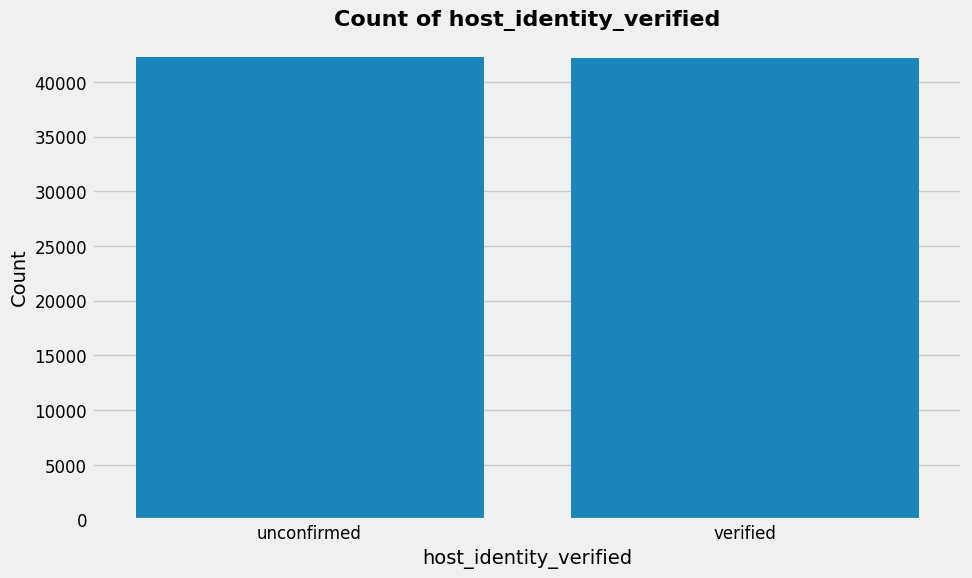

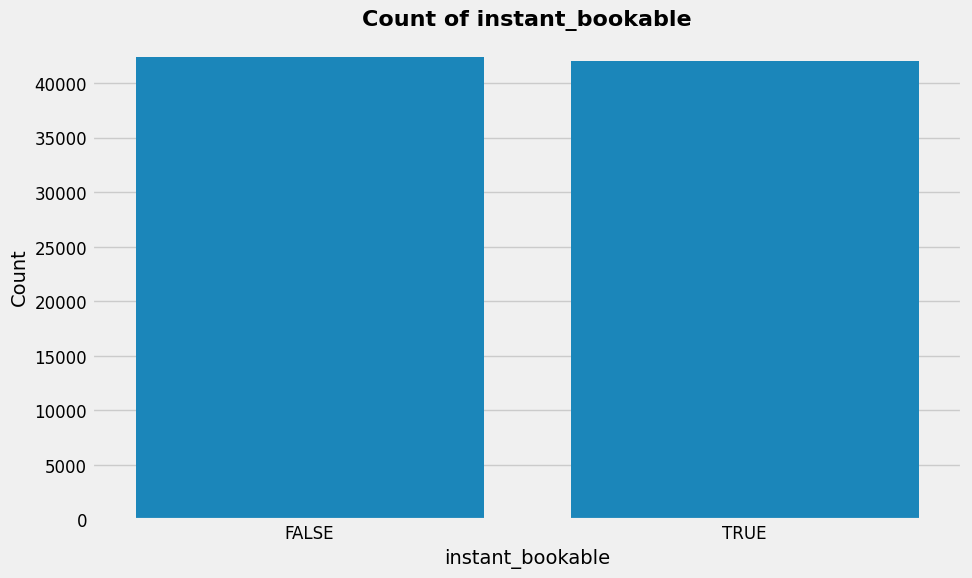

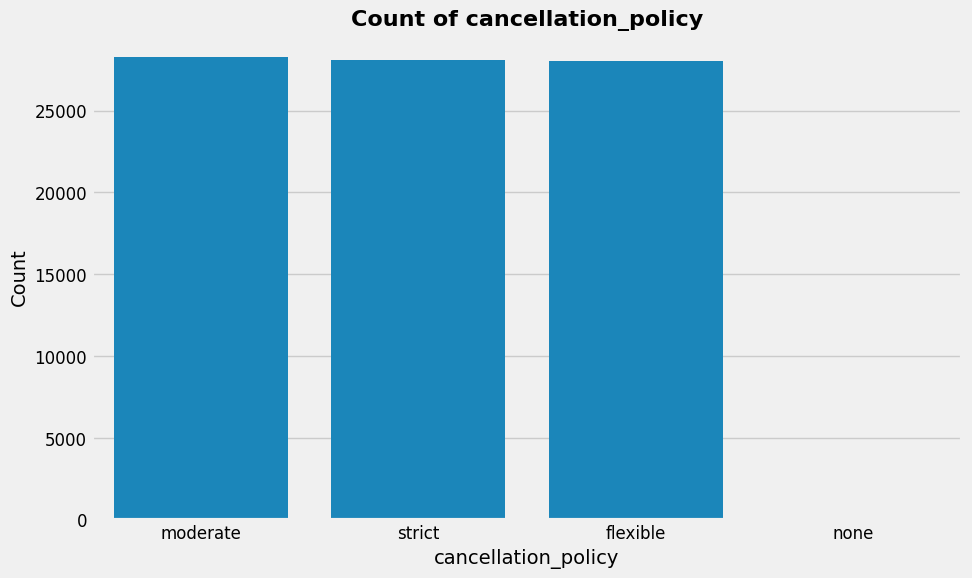

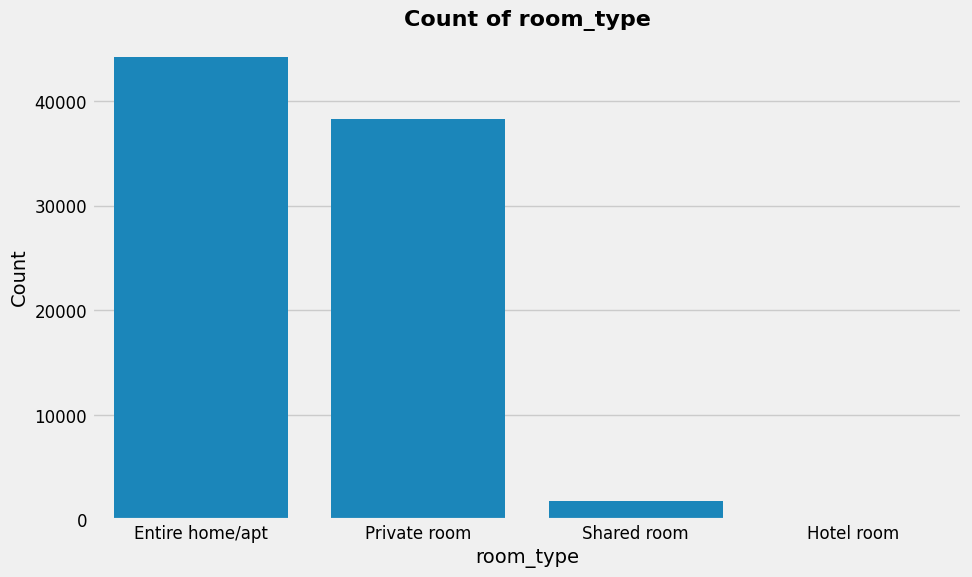

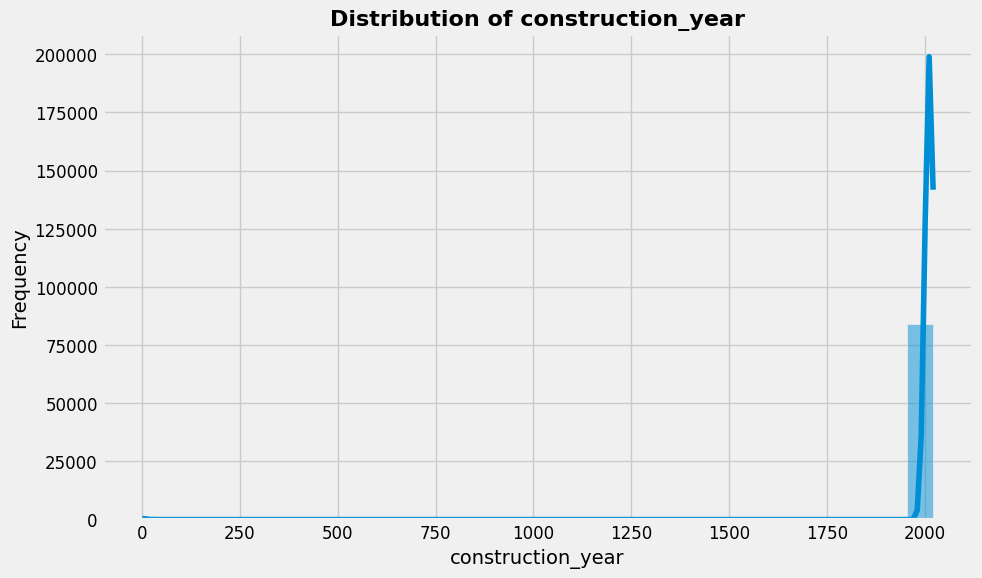

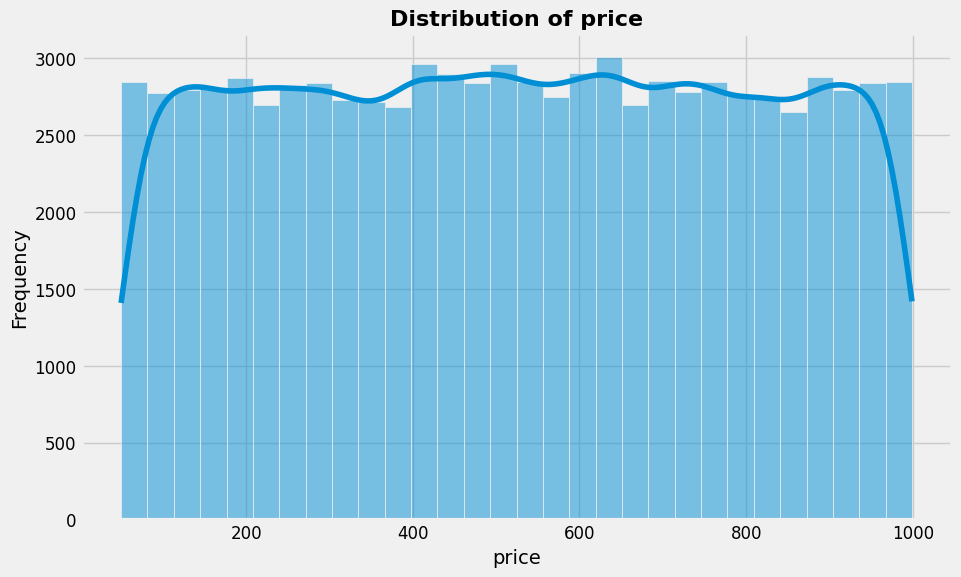

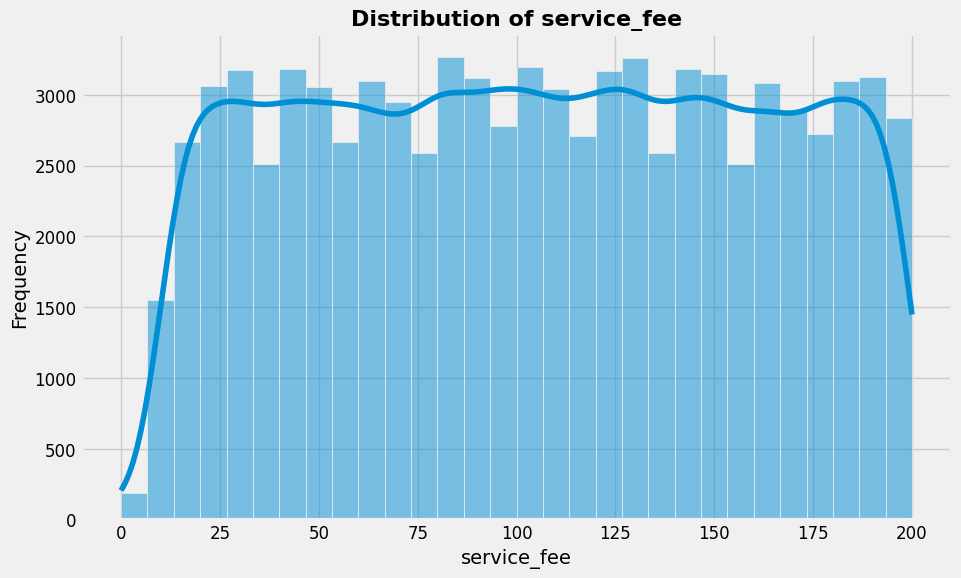

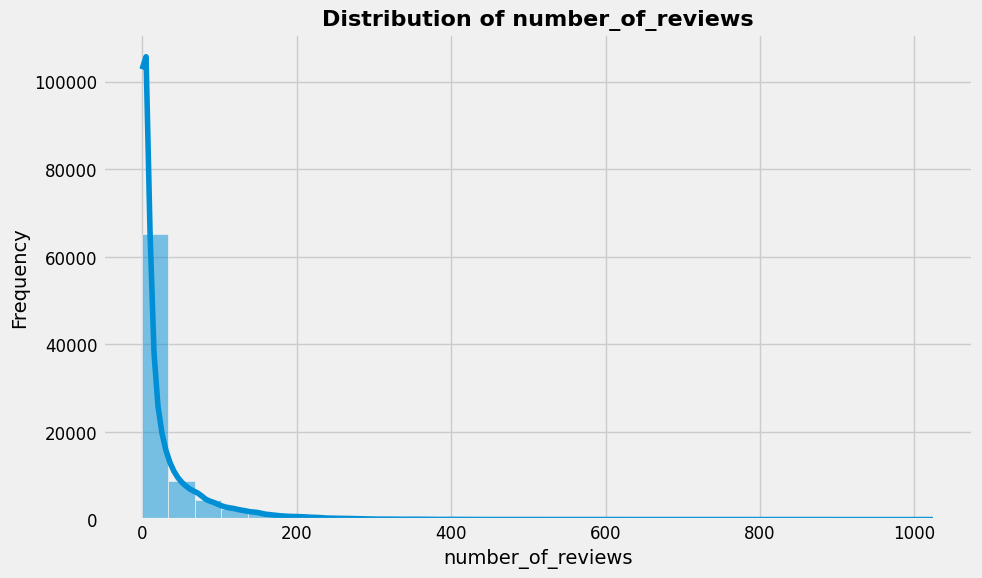

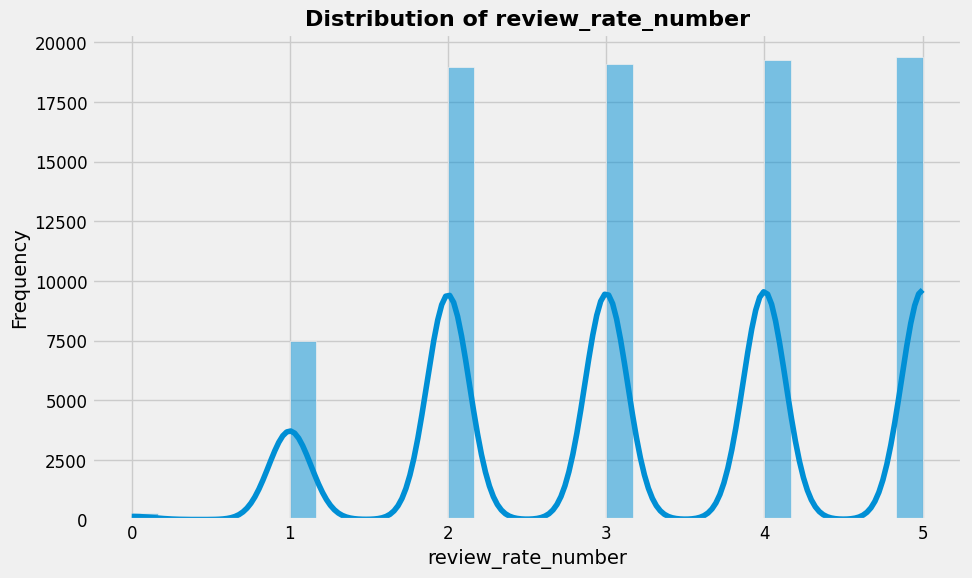

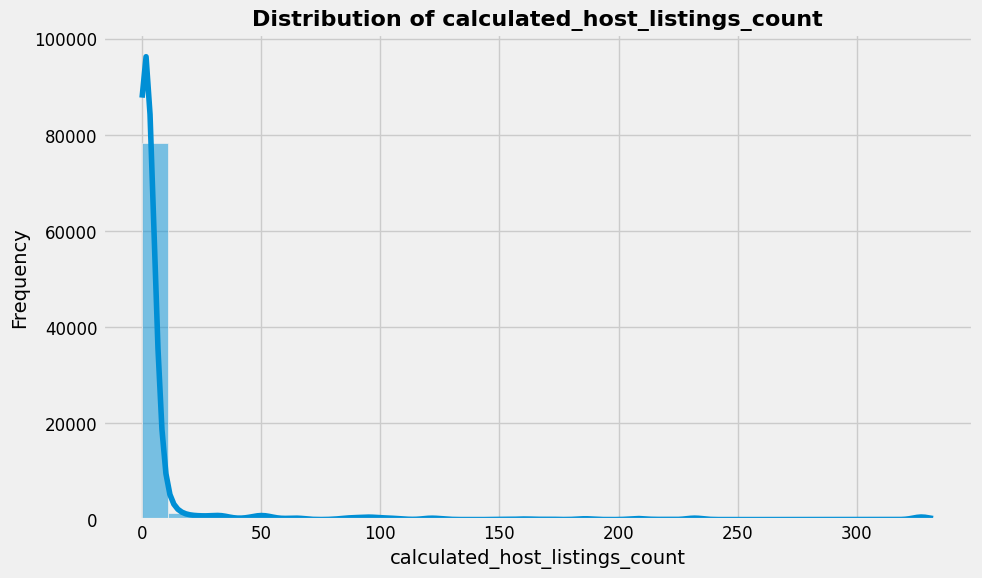

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd

# Thiết lập style cho biểu đồ
plt.style.use('fivethirtyeight')

# Thay đổi font mặc định nếu font 'Georgia' không có sẵn
plt.rcParams.update({'font.family': 'DejaVu Sans'})

# Danh sách các biến cần vẽ histogram
variables = ['host_identity_verified','instant_bookable','cancellation_policy','room_type','construction_year','price','service_fee','number_of_reviews','review_rate_number','calculated_host_listings_count']

# Đường dẫn đến thư mục lưu trữ biểu đồ
save_path = "C:/Users/giaha/Documents/BigData/histograms/"
# Tạo thư mục nếu chưa tồn tại
os.makedirs(save_path, exist_ok=True)

# Chuyển đổi DataFrame của PySpark sang Pandas DataFrame
df_pandas = df.toPandas()

# Tạo và lưu các biểu đồ histogram
for var in variables:
    plt.figure(figsize=(10, 6))

    if df_pandas[var].dtype == 'object':
        # Biểu đồ đếm (countplot) cho các biến phân loại
        sns.countplot(data=df_pandas, x=var, order=df_pandas[var].value_counts().index)
        plt.title(f'Count of {var}', fontsize=16, fontweight='bold')
        plt.xlabel(var, fontsize=14)
        plt.ylabel('Count', fontsize=14)
    else:
        # Biểu đồ histogram cho các biến số
        sns.histplot(df_pandas[var], bins=30, kde=True)
        plt.title(f'Distribution of {var}', fontsize=16, fontweight='bold')
        plt.xlabel(var, fontsize=14)
        plt.ylabel('Frequency', fontsize=14)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Lưu biểu đồ
    plt.savefig(os.path.join(save_path, f"{var}.png"), bbox_inches='tight')

    plt.show()


######*a. ‘price’ và 'host_identity_verified'*

In [ ]:
print(df)

DataFrame[host_identity_verified: string, instant_bookable: string, cancellation_policy: string, room_type: string, construction_year: int, price: float, service_fee: float, number_of_reviews: float, review_rate_number: float, calculated_host_listings_count: float]


<ipython-input-14-41d7936b8825>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='host_identity_verified', y='price', data=dft, order=['unconfirmed', 'verified'],
<ipython-input-14-41d7936b8825>:27: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(14)
<ipython-input-14-41d7936b8825>:29: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(14)


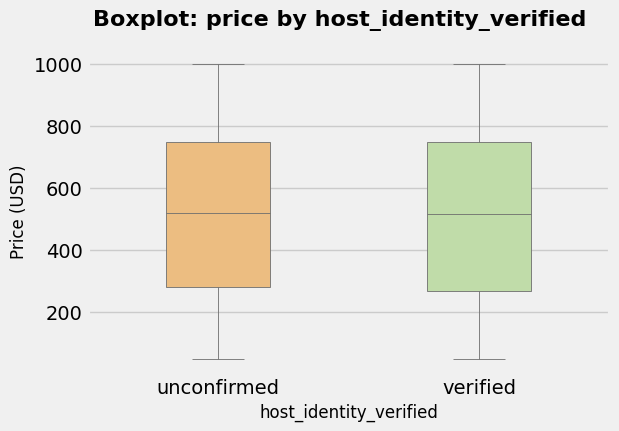

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Chuyển đổi DataFrame của PySpark sang pandas DataFrame
pandas_df = df.toPandas()

plt.figure(figsize=(6, 4))  # Đặt kích thước của biểu đồ

# Chọn các cột cần sử dụng
dft = pandas_df[["host_identity_verified", "price"]]

# Vẽ boxplot
sns.boxplot(x='host_identity_verified', y='price', data=dft, order=['unconfirmed', 'verified'],
            showfliers=False, palette="Spectral", linewidth=0.6, width=0.4)

# Điều chỉnh tiêu đề và nhãn của trục
ax = plt.gca()
ax.set_title("")  # Xóa tiêu đề
ax.set_ylabel("Price (USD)", fontsize=12)
ax.set_xlabel("host_identity_verified", fontsize=12)

plt.suptitle("Boxplot: price by host_identity_verified", fontweight="bold", fontsize=16)

# Điều chỉnh kích thước của các nhãn trên trục
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)

# Đường dẫn đến thư mục lưu trữ biểu đồ
save_path = "C:/Users/giaha/Documents/BigData/histograms/"
# Tạo thư mục nếu chưa tồn tại
os.makedirs(save_path, exist_ok=True)

# Lưu biểu đồ
plt.savefig(os.path.join(save_path, "host_identity_verified_price.png"), bbox_inches='tight')

# Hiển thị biểu đồ
plt.show()


######*b. ‘price’ và 'instant_bookable'*

<ipython-input-15-d61d3a536e45>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='instant_bookable', y='price', data=dft, order=['FALSE', 'TRUE'],
<ipython-input-15-d61d3a536e45>:27: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(14)
<ipython-input-15-d61d3a536e45>:29: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(14)


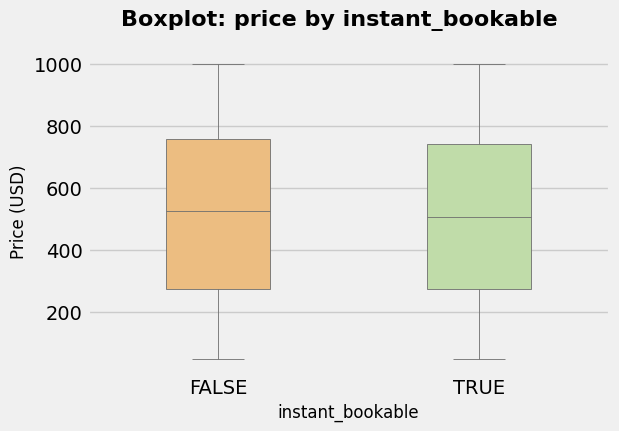

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Chuyển đổi DataFrame của PySpark sang pandas DataFrame
pandas_df = df.toPandas()

plt.figure(figsize=(6, 4))  # Đặt kích thước của biểu đồ

# Chọn các cột cần sử dụng
dft = pandas_df[["instant_bookable", "price"]]

# Vẽ boxplot
sns.boxplot(x='instant_bookable', y='price', data=dft, order=['FALSE', 'TRUE'],
            showfliers=False, palette="Spectral", linewidth=0.6, width=0.4)

# Điều chỉnh tiêu đề và nhãn của trục
ax = plt.gca()
ax.set_title("")  # Xóa tiêu đề
ax.set_ylabel("Price (USD)", fontsize=12)
ax.set_xlabel("instant_bookable", fontsize=12)

plt.suptitle("Boxplot: price by instant_bookable", fontweight="bold", fontsize=16)

# Điều chỉnh kích thước của các nhãn trên trục
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)

# Đường dẫn đến thư mục lưu trữ biểu đồ
save_path = "C:/Users/giaha/Documents/BigData/histograms/"
# Tạo thư mục nếu chưa tồn tại
os.makedirs(save_path, exist_ok=True)

# Lưu biểu đồ
plt.savefig(os.path.join(save_path, "instant_bookable_price.png"), bbox_inches='tight')

# Hiển thị biểu đồ
plt.show()


######*c. ‘price’ và 'cancellation_policy'*

<ipython-input-16-5d571c94e546>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cancellation_policy', y='price', data=dft, order=['moderate', 'strict','flexible','none'],
<ipython-input-16-5d571c94e546>:27: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(14)
<ipython-input-16-5d571c94e546>:29: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(14)


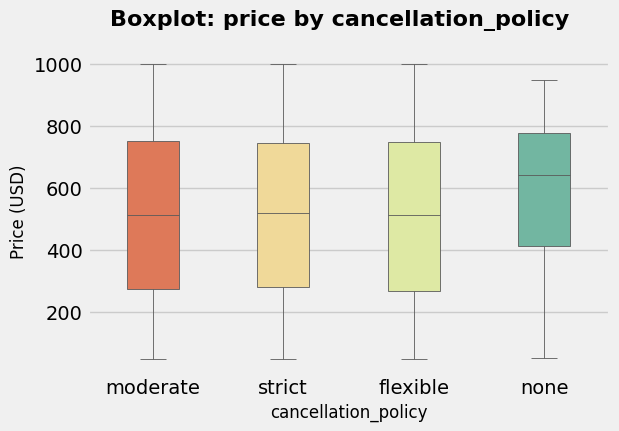

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Chuyển đổi DataFrame của PySpark sang pandas DataFrame
pandas_df = df.toPandas()

plt.figure(figsize=(6, 4))  # Đặt kích thước của biểu đồ

# Chọn các cột cần sử dụng
dft = pandas_df[["cancellation_policy", "price"]]

# Vẽ boxplot
sns.boxplot(x='cancellation_policy', y='price', data=dft, order=['moderate', 'strict','flexible','none'],
            showfliers=False, palette="Spectral", linewidth=0.6, width=0.4)

# Điều chỉnh tiêu đề và nhãn của trục
ax = plt.gca()
ax.set_title("")  # Xóa tiêu đề
ax.set_ylabel("Price (USD)", fontsize=12)
ax.set_xlabel("cancellation_policy", fontsize=12)

plt.suptitle("Boxplot: price by cancellation_policy", fontweight="bold", fontsize=16)

# Điều chỉnh kích thước của các nhãn trên trục
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)

# Đường dẫn đến thư mục lưu trữ biểu đồ
save_path = "C:/Users/giaha/Documents/BigData/histograms/"
# Tạo thư mục nếu chưa tồn tại
os.makedirs(save_path, exist_ok=True)

# Lưu biểu đồ
plt.savefig(os.path.join(save_path, "cancellation_policy_price.png"), bbox_inches='tight')

# Hiển thị biểu đồ
plt.show()


######*d. ‘price’ và 'room_type'*

<ipython-input-18-ec26c617b4f8>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='room_type', y='price', data=dft, order=['Entire home/apt', 'Private room','Shared room'],
<ipython-input-18-ec26c617b4f8>:27: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(14)
<ipython-input-18-ec26c617b4f8>:29: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(14)


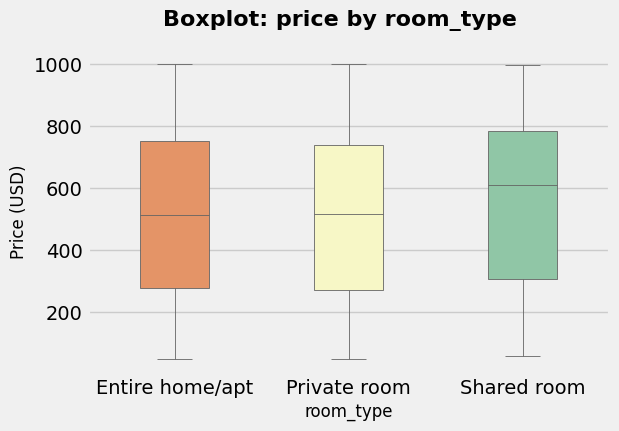

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Chuyển đổi DataFrame của PySpark sang pandas DataFrame
pandas_df = df.toPandas()

plt.figure(figsize=(6, 4))  # Đặt kích thước của biểu đồ

# Chọn các cột cần sử dụng
dft = pandas_df[["room_type", "price"]]

# Vẽ boxplot
sns.boxplot(x='room_type', y='price', data=dft, order=['Entire home/apt', 'Private room','Shared room'],
            showfliers=False, palette="Spectral", linewidth=0.6, width=0.4)

# Điều chỉnh tiêu đề và nhãn của trục
ax = plt.gca()
ax.set_title("")  # Xóa tiêu đề
ax.set_ylabel("Price (USD)", fontsize=12)
ax.set_xlabel("room_type", fontsize=12)

plt.suptitle("Boxplot: price by room_type", fontweight="bold", fontsize=16)

# Điều chỉnh kích thước của các nhãn trên trục
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)

# Đường dẫn đến thư mục lưu trữ biểu đồ
save_path = "C:/Users/giaha/Documents/BigData/histograms/"
# Tạo thư mục nếu chưa tồn tại
os.makedirs(save_path, exist_ok=True)

# Lưu biểu đồ
plt.savefig(os.path.join(save_path, "room_type_price.png"), bbox_inches='tight')

# Hiển thị biểu đồ
plt.show()


In [ ]:
import numpy as np  # Import thư viện NumPy
from pyspark.sql import SQLContext

import pandas as pd

# Chuyển PySpark DataFrame thành Pandas DataFrame
pandas_df = df.toPandas()

# Lọc các biến số từ Pandas DataFrame
numerical_df = pandas_df.select_dtypes(include=[np.number])

# Thêm cột 'price' nếu nó không nằm trong danh sách các cột số (trường hợp hiếm gặp)
if 'price' not in numerical_df.columns:
    numerical_df = numerical_df.join(df['price'])

# Tính toán ma trận tương quan chỉ với các cột số
corr_matrix = numerical_df.corr(method="pearson")

# Trích xuất tương quan với 'price'
dfc = pd.DataFrame(corr_matrix["price"])
dfc.reset_index(inplace=True)
dfc.columns = ["features", "correlation_with_price"]
dfc = dfc.sort_values("correlation_with_price", ascending=False)

# Lọc các biến có tương quan dương đáng kể
df1 = dfc[dfc["correlation_with_price"] > 0.1]

# Lấy danh sách các biến có tương quan đáng kể
corr_features = df1["features"].values
corr_features = corr_features.tolist()
corr_features.append("Price")

# Hiển thị DataFrame df1
df1


,features,correlation_with_price
1,price,1.000000
2,service_fee,0.994699


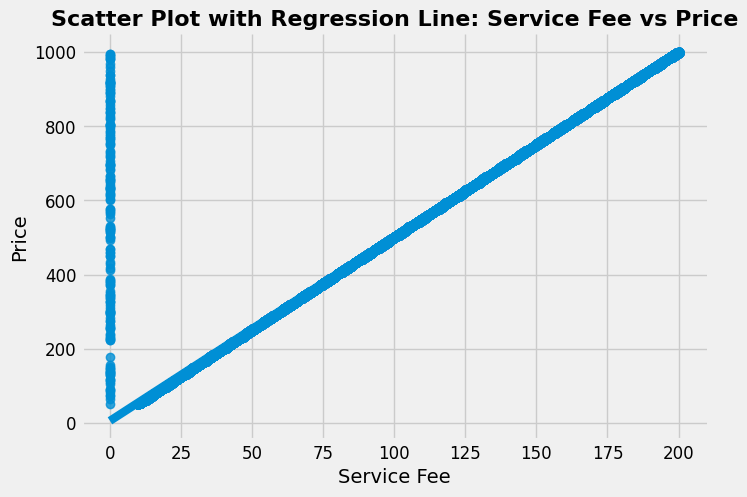

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

#Chuyển đổi DataFrame của PySpark sang Pandas DataFrame
df_pandas = df.toPandas()

#Vẽ biểu đồ phân tán với đường hồi quy
sns.lmplot(data=df_pandas,x='service_fee', y='price',aspect=1.5)
plt.title('Scatter Plot with Regression Line: Service Fee vs Price',fontsize =16, fontweight='bold')
plt.xlabel('Service Fee',fontsize =14)
plt.ylabel('Price',fontsize =14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


Model Training and Deployment

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from scipy.stats import probplot
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [ ]:
file_path = "/content/Preprocessed_airbnb_listing.csv"
df = pd.read_csv(file_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41134 entries, 0 to 41133
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   host_identity_verified          41134 non-null  object 
 1   instant_bookable                41134 non-null  bool   
 2   cancellation_policy             41134 non-null  object 
 3   room_type                       41134 non-null  object 
 4   construction_year               41134 non-null  int64  
 5   price                           41134 non-null  float64
 6   service_fee                     41134 non-null  float64
 7   number_of_reviews               41134 non-null  float64
 8   review_rate_number              41134 non-null  float64
 9   calculated_host_listings_count  41134 non-null  float64
dtypes: bool(1), float64(5), int64(1), object(3)
memory usage: 2.9+ MB


In [ ]:
#Chuyển những biến Category thành dạng số
df['instant_bookable'] = df['instant_bookable'].astype(int)
encoder = LabelEncoder()
for column in df.columns:
    if df[column].dtype == 'object':
        df[column] = encoder.fit_transform(df[column])
        print(f"\n Chuyển đổi '{column}' sang dữ liệu dạng số:")
        for original_category, encoded_value in zip(encoder.classes_, encoder.transform(encoder.classes_)):
            print(f"{original_category}: {encoded_value}")

df.head()


 Chuyển đổi 'host_identity_verified' sang dữ liệu dạng số:
unconfirmed: 0
verified: 1

 Chuyển đổi 'cancellation_policy' sang dữ liệu dạng số:
flexible: 0
moderate: 1
none: 2
strict: 3

 Chuyển đổi 'room_type' sang dữ liệu dạng số:
Entire home/apt: 0
Private room: 1
Shared room: 2


,host_identity_verified,instant_bookable,cancellation_policy,room_type,construction_year,price,service_fee,number_of_reviews,review_rate_number,calculated_host_listings_count
0,0,0,3,1,2020,966.0,193.0,9.0,4.0,6.0
1,1,0,1,0,2007,142.0,28.0,45.0,4.0,2.0
2,0,1,0,1,2005,620.0,124.0,0.0,5.0,1.0
3,0,1,1,0,2005,368.0,74.0,270.0,4.0,1.0
4,1,0,1,0,2009,204.0,41.0,9.0,3.0,1.0


In [ ]:
X = df[['host_identity_verified', 'instant_bookable',
       'cancellation_policy', 'room_type', 'construction_year',
       'service_fee', 'number_of_reviews', 'review_rate_number',
       'calculated_host_listings_count']]
y = df[ 'price']
# Chia tập dữ liệu
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Hiển thị cấu trúc của các tập
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((28793, 9), (28793,), (12341, 9), (12341,))

In [ ]:
models = []
models.append(("Linear Regression",LinearRegression()))
models.append(("Decision Tree", DecisionTreeRegressor()))
models.append(("Random Forest", RandomForestRegressor()))
# Đánh giá sơ bộ
for a,b in models:
    scoring_metrics = make_scorer(mean_absolute_error,
                              greater_is_better=False
                             ) # Hàm tính toán sai số tuyệt đối trung bình
    k_fold = KFold(n_splits=10, shuffle=True, random_state=123)
    # cross_val_score: Hàm từ sklearn.model_selection dùng để thực hiện cross-validation.
    cv = cross_val_score(b, X_train, y_train, scoring = scoring_metrics, cv = k_fold)
    result = (a, cv.mean(), cv.std()) #standard deviation
    print(result)

('Linear Regression', -3.635020344844711, 0.5347135798919509)
('Decision Tree', -2.3077311699181813, 0.2736978035651837)
('Random Forest', -1.793519258358645, 0.1930818293183076)


### Tìm siêu tham số cho từng mô hình sử dụng GridSearchCV

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, make_scorer

#Định nghĩa các mô hình và lưới tham số
param_grids = {
    "Linear Regression": {
        'model__fit_intercept': [True, False],
        'model__copy_X': [True, False]
    },
    "Decision Tree": {
        'model__max_depth': [1, 20, 100],
        'model__max_features': [1, 5, 15, 20],
        'model__max_leaf_nodes': [5, 50, 100]
    },
    "Random Forest": {
        'model__n_estimators': [3, 10, 100],
        'model__max_depth': [2, 10, 100],
        'model__max_features': [2, 10, 20]
    }
}

models = [
    ("Linear Regression", LinearRegression()),
    ("Decision Tree", DecisionTreeRegressor()),
    ("Random Forest", RandomForestRegressor())
]

# Định nghĩa hàm đánh giá
scoring_metrics = make_scorer(mean_absolute_error, greater_is_better=False)

# Thiết lập K-Fold cross-validation
k_fold = KFold(n_splits=10, shuffle=True, random_state=123)

# Tìm tham số tốt nhất cho từng mô hình và đánh giá
for a, b in models:
    print(f"Optimizing {a}...")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', b)
    ])
    grid_search = GridSearchCV(pipeline, param_grids[a], scoring=scoring_metrics, cv=k_fold)
    grid_search.fit(X_train, y_train)

    # In ra các tham số tốt nhất
    print(f"Best parameters for {a}:", grid_search.best_params_)

    # Sử dụng mô hình với tham số tốt nhất
    best_model = grid_search.best_estimator_

Optimizing Linear Regression...
Best parameters for Linear Regression: {'model__copy_X': True, 'model__fit_intercept': True}
Optimizing Decision Tree...
Best parameters for Decision Tree: {'model__max_depth': 100, 'model__max_features': 15, 'model__max_leaf_nodes': 100}
Optimizing Random Forest...
Best parameters for Random Forest: {'model__max_depth': 10, 'model__max_features': 10, 'model__n_estimators': 100}


###Tìm siêu tham số cho từng mô hình Decision Tree sử dụng RandomizedSearchCV

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, make_scorer
from scipy.stats import randint

# Định nghĩa các mô hình và lưới tham số cho RandomizedSearchCV
param_distributions = {
    "Linear Regression": {
        'model__fit_intercept': [True, False],
        'model__copy_X': [True, False]
    },
    "Decision Tree": {
        'model__max_depth': randint(1, 101),
        'model__max_features': randint(1, 21),
        'model__max_leaf_nodes': randint(5, 101)
    }
}

models = [
    ("Linear Regression", LinearRegression()),
    ("Decision Tree", DecisionTreeRegressor()),
]

# Định nghĩa hàm đánh giá
scoring_metrics = make_scorer(mean_absolute_error, greater_is_better=False)

# Thiết lập K-Fold cross-validation
k_fold = KFold(n_splits=10, shuffle=True, random_state=123)

# Tìm tham số tốt nhất cho từng mô hình và đánh giá
for a, b in models:
    print(f"Optimizing {a}...")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', b)
    ])
    random_search = RandomizedSearchCV(pipeline, param_distributions[a], scoring=scoring_metrics, cv=k_fold, n_iter=50, random_state=123)
    random_search.fit(X_train, y_train)

    # In ra các tham số tốt nhất
    print(f"Best parameters for {a}:", random_search.best_params_)

    # Sử dụng mô hình với tham số tốt nhất
    best_model = random_search.best_estimator_

    # Đánh giá mô hình với cross-validation
    cv = cross_val_score(best_model, X_train, y_train, scoring=scoring_metrics, cv=k_fold)
    result = (a, cv.mean(), cv.std()) # độ lệch chuẩn
    print(result)


Optimizing Linear Regression...


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=50. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters for Linear Regression: {'model__fit_intercept': True, 'model__copy_X': True}
('Linear Regression', -5.704822688426598, 0.37161711974107053)
Optimizing Decision Tree...
Best parameters for Decision Tree: {'model__max_depth': 7, 'model__max_features': 10, 'model__max_leaf_nodes': 92}
('Decision Tree', -4.551075938750533, 0.29464707041606086)


### Đánh giá 3 mô hình với siêu tham số


In [ ]:
models = [
    ("Linear Regression", LinearRegression(copy_X=True, fit_intercept=True)),
    ("Decision Tree", DecisionTreeRegressor(max_depth=100, max_features=15, max_leaf_nodes=100, random_state=42)),
    ("Random Forest", RandomForestRegressor(max_depth=10, max_features=10, n_estimators=100, random_state=42))
]

# Hàm để đánh giá mô hình
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return rmse, mae, r2

# Đánh giá và so sánh các mô hình
results = []

for name, model in models:
    rmse, mae, r2 = evaluate_model(model, X_train, y_train, X_test, y_test)
    results.append((name, rmse, mae, r2))

# Chuyển đổi kết quả thành DataFrame
results_df = pd.DataFrame(results, columns=['Model', 'RMSE', 'MAE', 'R^2'])

print(results_df)

               Model       RMSE       MAE       R^2
0  Linear Regression  26.889272  3.363184  0.990444
1      Decision Tree  16.259580  4.247847  0.996506
2      Random Forest  13.522706  1.695463  0.997583


### **Thực hiện dự báo định giá nhà trên tập kiểm thử**

Dự đoán trên bộ test và xuất kết quả nhằm so sánh mức độ dự đoán chính xác.

In [ ]:
# Import mô hình Random Forest Regressor từ thư viện sklearn.ensemble
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# Đặt biến X, y với X chứa các cột features và y là cột target
X = df[['host_identity_verified', 'instant_bookable', 'cancellation_policy',
       'room_type', 'construction_year', 'service_fee',
       'number_of_reviews', 'review_rate_number',
       'calculated_host_listings_count']]
y = df[ 'price']

In [ ]:
# Chia bộ data theo tỷ lệ 7:3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Gán biến best_model là mô hình với các tham số tốt nhất đã được chọn ra từ Grid Search ở trên
best_model = RandomForestRegressor(max_depth=10, max_features=10, n_estimators=100, random_state=42)

In [ ]:
# Fit model vào tập train
best_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, max_features=10, random_state=42)

In [ ]:
# Áp dụng model vào X test để dự đoán ra cột giá (gán biến 'y_pred')
y_pred = best_model.predict(X_test)
print (y_pred)

[360.10384752 870.05835914 874.83824896 ...  60.00904414 844.85462217
 475.34401215]


In [ ]:
# Tạo dataframe so sánh giá trị thực tế và giá trị dự đoán
df_comparison = pd.DataFrame({'actual:': y_test, 'prediction': y_pred})
df_comparison

,actual:,prediction
15610,359.0,360.103848
6730,868.0,870.058359
6515,876.0,874.838249
12558,303.0,304.651258
25152,870.0,870.274555
...,...,...
15180,600.0,599.814719
11389,650.0,650.182442
795,59.0,60.009044
581,845.0,844.854622


In [ ]:
# Xuất CSV
df_comparison.to_csv('Comparison_Act_vs_Pred.csv', index=False)

### **Kết quả đếm số dự đoán lệch dưới 2.5 đô --> % Dự đoán lệch dưới 2.5 đô: 98.31%**

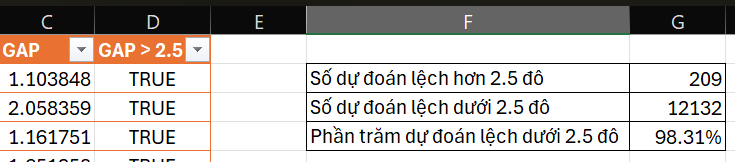